In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
import matplotlib.pylab as pylab
import matplotlib.colors as colors
import matplotlib.cm as cmx

import astropy.constants as const
import astropy.cosmology

from scipy.optimize import minimize
import emcee
import corner

from pynverse import inversefunc
from scipy.interpolate import interp1d

In [131]:
# commonly used functions
def LL(theory,data,cov):
    '''
    Computes the Log-Likelihood for mock cosmo data generated from a model
    mu_theory,data are 1-D arrays of len N
    cov is 2-D array of shape (N,N)
    for SN, N=40
    LRG N=6 ordered such that h0,dc0,h1,dc1,h2,dc2
    '''
    icov = np.linalg.inv(cov)
    residual = theory - data
    return np.einsum('i,ij,j',residual,icov,residual)

def z_sampling(N,zmax,seed,fileprefix):
    z = np.linspace(0,zmax,100)

    LCDM = astropy.cosmology.w0waCDM(H0=73.,Om0=0.25,Ode0=0.75,w0=-1,wa=0.)
    DH = const.c.to('km/s').value/LCDM.H(z).value
    DC = LCDM.comoving_distance(z).value

    dNdz = DH*DC**2
    dNdz_func = interp1d(z, dNdz)
    N_z = np.trapz(dNdz,z)

    def N_z_func(z):
        z_arr = np.linspace(0,z,100)
        z_arr1 = np.linspace(0,zmax,100)
        Nz = np.trapz(dNdz_func(z_arr),z_arr) / np.trapz(dNdz_func(z_arr1),z_arr1)
        return Nz

    def inv_func(x):
        z_N = np.empty_like(x)
        for i in range(len(x)):
            inv = inversefunc(N_z_func,domain=[0,zmax])
            z_N[i] = inv(x[i])
        return z_N

    generator = np.random.RandomState([11235813,seed])
    x0 = generator.uniform(0,1,N)
    z_sample = inv_func(x0)

    fig = plt.figure('redshifts',figsize=(5.5,3.5))
    fig.subplots_adjust(left=0.12,bottom=0.14,right=0.99,
                        top=0.99,wspace=0.05,hspace=0.0)
    plt.hist(z_sample)
    plt.xlabel(r'$z$',fontsize=14)
    plt.ylabel(r'$N(z)$',fontsize=14)
    plt.savefig(fileprefix+str(N)+'_'+str(seed)+'.pdf')
    plt.show()
    np.savetxt(fileprefix+str(N)+'_'+str(seed)+'.txt',z_sample)
    return z_sample

def DL_sampling(z_sample,rel_err,N,cosmo,seed):   
    DL_w0wa = cosmo.luminosity_distance(z_sample).value
    sigma_w0wa = rel_err*DL_w0wa
    generator2 = np.random.RandomState([12345678,seed])
    DL_w0wa_res = DL_w0wa + generator2.normal(0,sigma_w0wa,N)
    return DL_w0wa_res,sigma_w0wa

def MCMC_inf(DL_w0wa_res,sigma_w0wa,prior,x0):
    ndim=2
    GW_mean = DL_w0wa_res
    GW_cov = np.diag(sigma_w0wa**2)
    
    def omh2_prior(x):
        #1807.06209 table 2 TTTEEE+lowE+lensing
        h,Omega_m = x
        return (Omega_m*h**2-0.1430)**2/(0.0011)**2

    def global_chi_sqd(x):
        if np.any(x<0):
            return np.inf
        else:
            h,Omega_m = x
            cosmo_model = astropy.cosmology.FlatLambdaCDM(H0=100.*h,Om0=Omega_m)
            GW_pred = cosmo_model.luminosity_distance(z_sample).value
            LL_GW = LL(GW_pred,GW_mean,GW_cov)
            if prior:
                CMB_prior = omh2_prior(x)
            else:
                CMB_prior = 0
            return LL_GW + CMB_prior

    def lnprob(x):
        return -0.5*global_chi_sqd(x)

    print(x0)
    print(global_chi_sqd(x0))

    res = minimize(global_chi_sqd,x0,method='Nelder-Mead', tol=1e-6)
    print(res.x)
    print(global_chi_sqd(res.x))

    nwalkers = 20
    nMCMC = 5000
    pos = [res.x * 1.01**np.random.randn(ndim) for k in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(pos, nMCMC)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

def MCMC_inf4D(DL_w0wa_res,sigma_w0wa,prior,x0):
    ndim=4
    GW_mean = DL_w0wa_res
    GW_cov = np.diag(sigma_w0wa**2)
    
    def omh2_prior(x):
        #1807.06209 table 2 TTTEEE+lowE+lensing
        h,Omega_m,w0,wa = x
        return (Omega_m*h**2-0.1430)**2/(0.0011)**2

    def global_chi_sqd(x):
        #print(x)
        if np.any(x[0:2]<0) or x[2]>0 or x[2] < -3 or x[2]+x[3]/2>0 or x[2]+x[3]/2<-3:
            #print(x[0:2])
            return np.inf
        else:
            h,Omega_m,w0,wa = x
            cosmo_model = astropy.cosmology.Flatw0waCDM(H0=100.*h,Om0=Omega_m,w0=w0,wa=wa)
            GW_pred = cosmo_model.luminosity_distance(z_sample).value
            LL_GW = LL(GW_pred,GW_mean,GW_cov)
            if prior:
                CMB_prior = omh2_prior(x)
            else:
                CMB_prior = 0
            return LL_GW + CMB_prior

    def lnprob(x):
        return -0.5*global_chi_sqd(x)

    print(x0)
    print(global_chi_sqd(x0))

    res = minimize(global_chi_sqd,x0,method='Nelder-Mead', tol=1e-6)
    print(res.x)
    print(global_chi_sqd(res.x))

    nwalkers = 40
    nMCMC = 10000
    pos = [res.x * 1.01**np.random.randn(ndim) for k in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(pos, nMCMC)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

def MCMC_inf4D_fixOm(DL_w0wa_res,sigma_w0wa,prior,x0):
    ndim=3
    GW_mean = DL_w0wa_res
    GW_cov = np.diag(sigma_w0wa**2)
    
    def omh2_prior(x):
        #1807.06209 table 2 TTTEEE+lowE+lensing
        h,w0,wa = x
        return (Omega_m*h**2-0.1430)**2/(0.0011)**2

    def global_chi_sqd(x):
        #print(x)
        if np.any(x[0:1]<0) or x[1]>0 or x[1] < -3 or x[1]+x[2]/2>0 or x[1]+x[2]/2<-3:
            #print(x[0:2])
            return np.inf
        else:
            h,w0,wa = x
            cosmo_model = astropy.cosmology.Flatw0waCDM(H0=100.*h,Om0=0.3,w0=w0,wa=wa)
            GW_pred = cosmo_model.luminosity_distance(z_sample).value
            LL_GW = LL(GW_pred,GW_mean,GW_cov)
            if prior:
                CMB_prior = omh2_prior(x)
            else:
                CMB_prior = 0
            return LL_GW + CMB_prior

    def lnprob(x):
        return -0.5*global_chi_sqd(x)

    print(x0)
    print(global_chi_sqd(x0))

    res = minimize(global_chi_sqd,x0,method='Nelder-Mead', tol=1e-6)
    print(res.x)
    print(global_chi_sqd(res.x))

    nwalkers = 40
    nMCMC = 10000
    pos = [res.x * 1.01**np.random.randn(ndim) for k in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(pos, nMCMC)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

def MCMC_inf1d(DL_w0wa_res,sigma_w0wa,Om_fix,x0):
    ndim=1
    GW_mean = DL_w0wa_res
    GW_cov = np.diag(sigma_w0wa**2)

    def global_chi_sqd(x):
        if np.any(x<0):
            return np.inf
        else:
            h, = x
            cosmo_model = astropy.cosmology.FlatLambdaCDM(H0=100.*h,Om0=Om_fix)
            GW_pred = cosmo_model.luminosity_distance(z_sample).value
            LL_GW = LL(GW_pred,GW_mean,GW_cov)
            return LL_GW

    def lnprob(x):
        return -0.5*global_chi_sqd(x)

    print(x0)
    print(global_chi_sqd(x0))

    res = minimize(global_chi_sqd,x0,method='Nelder-Mead', tol=1e-6)
    print(res.x)
    print(global_chi_sqd(res.x))

    nwalkers = 20
    nMCMC = 5000
    pos = [res.x * 1.01**np.random.randn(ndim) for k in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(pos, nMCMC)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

def post_plot(samples,filename,Truths,names,ranges=None):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)  
    fig = corner.corner(samples, labels=names,quantiles=(0.16, 0.84), levels=(0.68,0.95,0.99,),
                       bins=40,truths=Truths,plot_datapoints=False,
                           color='#1f77b4',fill_contours=True,truth_color='k',range=ranges,
                        show_titles=True,title_fmt='.4f') 
    plt.savefig(filename)
    
def post_plot4D(samples,filename,Truths,names):
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)  
    fig = corner.corner(samples, labels=names,quantiles=(0.16, 0.84), levels=(0.68,0.95,0.99,),
                       bins=40,truths=Truths,plot_datapoints=False,
                           color='#1f77b4',fill_contours=True,truth_color='k',
                        show_titles=True,title_fmt='.4f') 
    plt.savefig(filename)    
    
def post_plot1d(samples,filename,xrange,Truths):
    names = [r'$h$']
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)  
    fig = corner.corner(samples, labels=names,quantiles=(0.16, 0.84), levels=(0.68,0.95,0.99,),
                       bins=40,truths=Truths,plot_datapoints=False,
                           color='#1f77b4',fill_contours=True,truth_color='k',
                        show_titles=True,title_fmt='.4f') 
    plt.xlim(xrange)
    plt.savefig(filename)
    
def post_plot1d_2(samples,samples2,filename,xrange):
    '''
    This isn't working.  I'm not sure how to pass get the 2 posteriors to be plotted 
    on 1 figure.
    '''
    names = [r'$h$']
    Truths = [0.73]
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)
    fig = plt.figure('1D',figsize=(4.,4.))
    
    fig1 = corner.corner(samples, labels=names,quantiles=(0.16, 0.84), levels=(0.68,0.95,0.99,),
                       bins=40,truths=Truths,plot_datapoints=False,
                           color='#1f77b4',fill_contours=True,truth_color='k',fig=fig,
                        show_titles=True,title_fmt='.4f') 
    fig2 = corner.corner(samples2, labels=names,quantiles=(0.16, 0.84), levels=(0.68,0.95,0.99,),
                       bins=40,truths=Truths,plot_datapoints=False,
                           color='#1f77b4',fill_contours=True,truth_color='k',fig=fig,
                        show_titles=True,title_fmt='.4f')
    plt.xlim(xrange)
    plt.savefig(filename)    
    
def DL_plot(samples,zmax,cosmo,filename):
    n_MCMC,n_dim = samples.shape
    i_plot = np.unique(np.random.randint(n_MCMC,size=100))
    z = np.linspace(0,zmax,100)
    DL_w0wa = cosmo.luminosity_distance(z).value
    fig = plt.figure('distances',figsize=(6.25,4.5))
    fig.subplots_adjust(left=0.08,bottom=0.065,right=0.985,
                        top=0.985,wspace=0.05,hspace=0.0)
    plt.plot(z,DL_w0wa,'k')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$D_L$ [Mpc]')
    for i in i_plot:
        h,Omega_m = samples[i,:]
        cosmo = astropy.cosmology.w0waCDM(H0=100*h,Om0=Omega_m,Ode0=1-Omega_m,w0=-1.0,wa=0.0)
        DL = cosmo.luminosity_distance(z).value
        cosmo2 = astropy.cosmology.FlatLambdaCDM(H0=100.*h,Om0=Omega_m)
        DL2 = cosmo2.luminosity_distance(z).value
        plt.plot(z,DL,color='#1f77b4')
        plt.plot(z,DL2,color='#1f77b4')
    plt.plot(z,DL_w0wa,'k',linewidth=2.0)    
    plt.savefig(filename)  
    plt.show()
    
def DL_ratio_plot(samples,zmax,cosmo,filename):
    n_MCMC,n_dim = samples.shape
    i_plot = np.unique(np.random.randint(n_MCMC,size=100))
    z = np.linspace(0,zmax,100)
    DL_w0wa = cosmo.luminosity_distance(z).value
    fig = plt.figure('distances',figsize=(6.25,4.5))
    fig.subplots_adjust(left=0.08,bottom=0.065,right=0.985,
                        top=0.985,wspace=0.05,hspace=0.0)
    plt.xlabel(r'$z$')
    plt.ylabel(r'$D_L/D_L^0$')
    for i in i_plot:
        h,Omega_m = samples[i,:]
        cosmo2 = astropy.cosmology.FlatLambdaCDM(H0=100.*h,Om0=Omega_m)
        DL = cosmo2.luminosity_distance(z).value
        plt.plot(z,DL/DL_w0wa,color='#1f77b4')
    plt.plot(z,np.ones(len(z)),'k--',linewidth=2.0)    
    plt.savefig(filename)  
    plt.show()
    
def DL_ratio_plot4D(samples,zmax,cosmo,filename):
    n_MCMC,n_dim = samples.shape
    i_plot = np.unique(np.random.randint(n_MCMC,size=100))
    z = np.linspace(0,zmax,100)
    DL_w0wa = cosmo.luminosity_distance(z).value
    fig = plt.figure('distances',figsize=(6.25,4.5))
    fig.subplots_adjust(left=0.08,bottom=0.065,right=0.985,
                        top=0.985,wspace=0.05,hspace=0.0)
    plt.xlabel(r'$z$')
    plt.ylabel(r'$D_L/D_L^0$')
    for i in i_plot:
        h,Omega_m,w0,wa = samples[i,:]
        cosmo2 = astropy.cosmology.Flatw0waCDM(H0=100.*h,Om0=Omega_m,w0=w0,wa=wa)
        DL = cosmo2.luminosity_distance(z).value
        plt.plot(z,DL/DL_w0wa,color='#1f77b4')
    plt.plot(z,np.ones(len(z)),'k--',linewidth=2.0)    
    plt.savefig(filename)  
    plt.show()    
    
def dchi2_inf(DL_w0wa_res,sigma_w0wa,x0):
    ndim=2
    GW_mean = DL_w0wa_res
    GW_cov = np.diag(sigma_w0wa**2)

    def global_chi_sqd(x):
        if np.any(x<0):
            return np.inf
        else:
            h,Omega_m = x
            cosmo_model = astropy.cosmology.FlatLambdaCDM(H0=100.*h,Om0=Omega_m)
            GW_pred = cosmo_model.luminosity_distance(z_sample).value
            LL_GW = LL(GW_pred,GW_mean,GW_cov)
            return LL_GW

    def lnprob(x):
        return -0.5*global_chi_sqd(x)

    #print(x0)
    #print(global_chi_sqd(x0))

    res = minimize(global_chi_sqd,x0,method='Nelder-Mead', tol=1e-6)
    print(res.x)
    dchi2 = global_chi_sqd(x0)-global_chi_sqd(res.x)
    print(dchi2)
    return res.x, dchi2
    

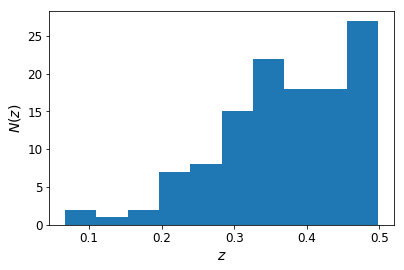

[0.7324 0.2666]
113.04133838786066
[0.68443016 0.58560251]
110.81101822301532


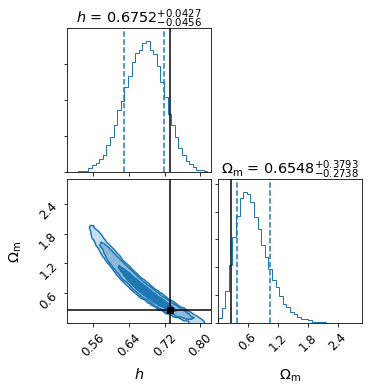

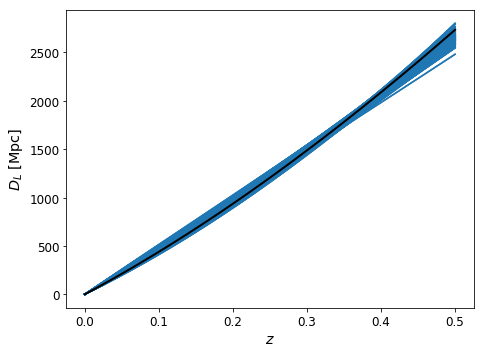

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


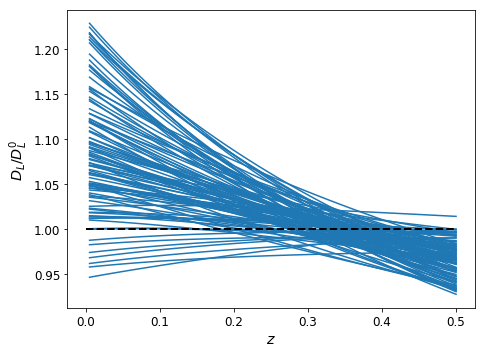

[0.7324]
113.04133838786066
[0.73852536]
112.54916740993534
[0.7324]
120.67684203680152
[0.70533061]
111.06294198508598


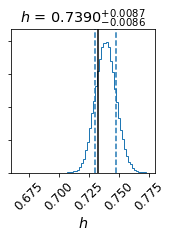

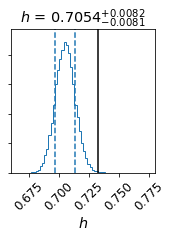

In [24]:
# Realistic Case - w0wa =(-0.9,-0.75)
N = 120
rel_err = 0.13
# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-0.9,wa=-0.75)
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-0.9,wa=-0.75)

zmax=0.5

Truths = [0.7324,0.2666]
x0 = np.array([0.7324,0.2666])


z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,20)
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_10yr.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio.png')

samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
post_plot1d(samples,'GW_10yr_1D.png',[0.66,0.78],[0.7324])

samples2 = MCMC_inf1d(DL_res,sigma,0.45,np.array([0.7324]))
post_plot1d(samples2,'GW_10yr_1D_2.png',[0.66,0.78],[0.7324])



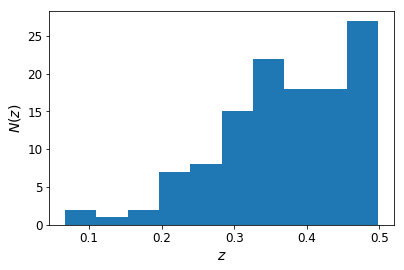

[0.69 0.3 ]
120.11404944682829
[0.66331214 0.37424413]
116.99689152779271


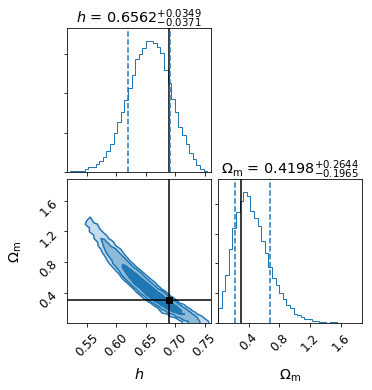

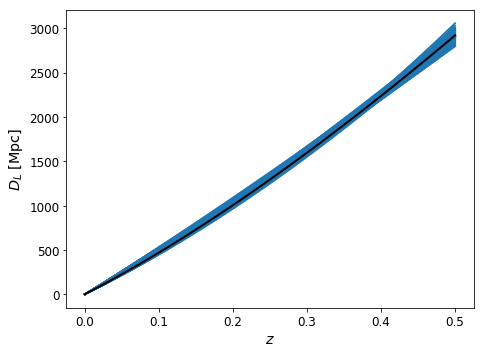

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


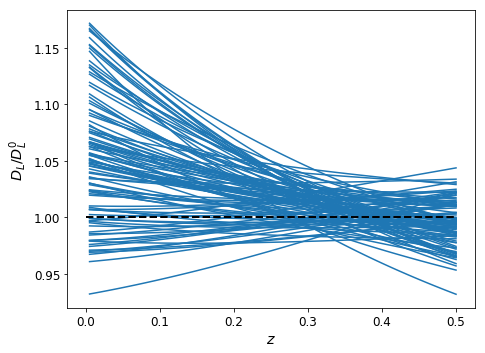

In [69]:
# Realistic Case - w0wa =(-1.14,0.35)
N = 120
rel_err = 0.13
zmax=0.5

Truths = [0.69,0.3]
x0 = np.array(Truths)
# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.14,wa=0.35)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,24)
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_10yr_w0wa3.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist_w0wa3.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_w0wa3.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_10yr_1D_w0wa2.png',[0.66,0.78],[0.7324])

#samples2 = MCMC_inf1d(DL_res,sigma,0.45,np.array([0.7324]))
#post_plot1d(samples2,'GW_10yr_1D_2_w0wa2.png',[0.66,0.78],[0.7324])



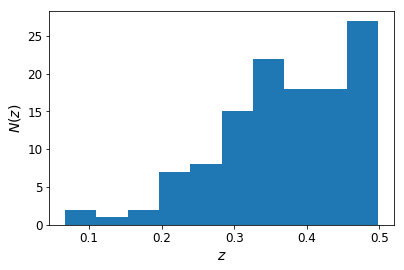

[0.69 0.3 ]
113.01385853917431
[0.64288695 0.64132061]
110.75075702297997


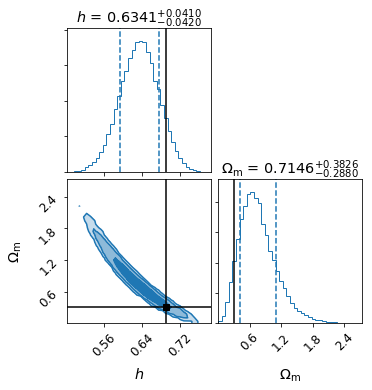

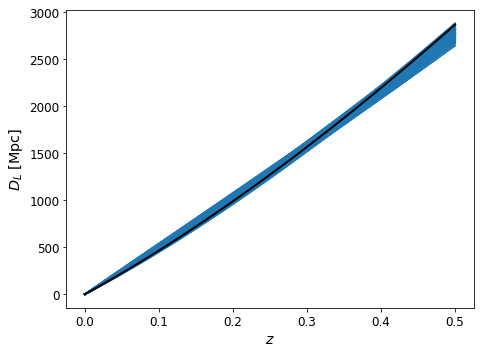

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


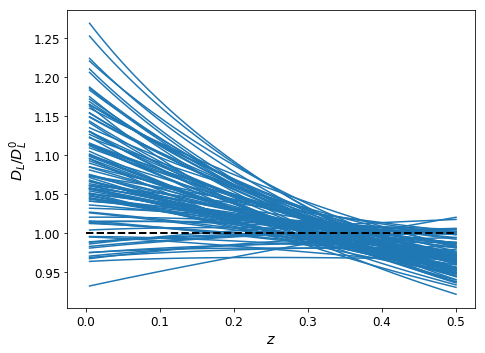

In [66]:
# Realistic Case - w0wa =(-0.9,-0.75)
N = 120
rel_err = 0.13
zmax=0.5

Truths = [0.69,0.3]
x0 = np.array(Truths)
# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-0.9,wa=-0.75)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,9)#54
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_10yr_w0wa2.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist_w0wa2.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_w0wa2.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_10yr_1D_w0wa2.png',[0.66,0.78],[0.7324])

#samples2 = MCMC_inf1d(DL_res,sigma,0.45,np.array([0.7324]))
#post_plot1d(samples2,'GW_10yr_1D_2_w0wa2.png',[0.66,0.78],[0.7324])

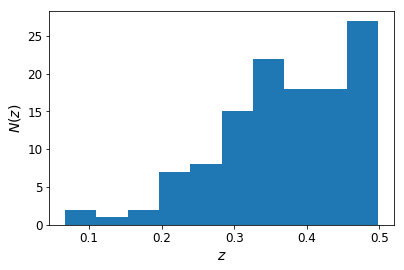

[0.69 0.3 ]
124.80405905984935
[0.69301181 0.2842617 ]
124.79641686541498


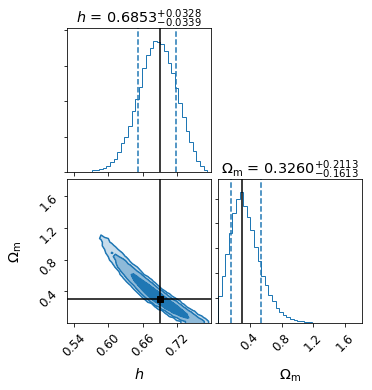

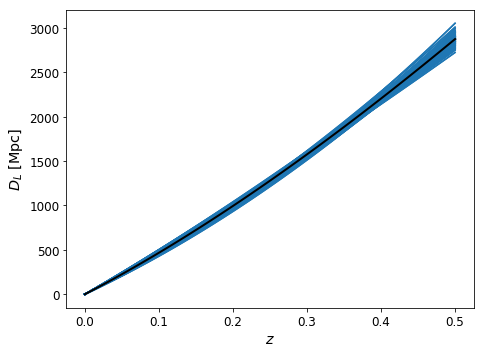

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


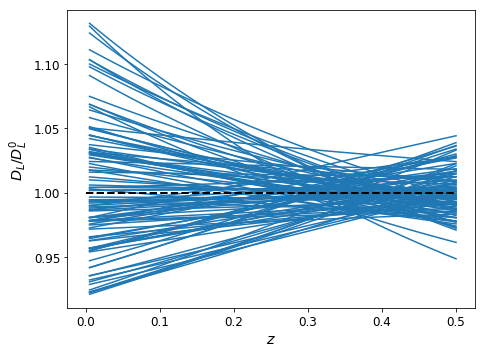

In [58]:
# Realistic Case - LCDM
N = 120
rel_err = 0.13

Truths = [0.69,0.3]
x0 = np.array(Truths)

# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-1.0,wa=0.0)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.0,wa=0.0)
zmax=0.5

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,25)
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_10yr_LCDM2.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist_LCDM2.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_LCDM2.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_10yr_1D_LCDM.png',[0.66,0.78],[0.7324])

#samples2 = MCMC_inf1d(DL_res,sigma,0.45,np.array([0.7324]))
#post_plot1d(samples2,'GW_10yr_1D_2_LCDM.png',[0.66,0.78],[0.7324])



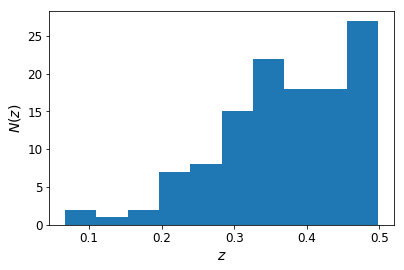

[ 0.69  0.3  -1.    0.  ]
124.80405905984935
[ 7.56505220e-01  4.46317527e-01 -3.00000000e+00  1.64219043e-03]
123.4472775944231


/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


ValueError: too many values to unpack (expected 2)

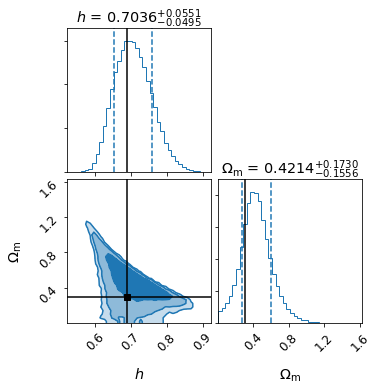

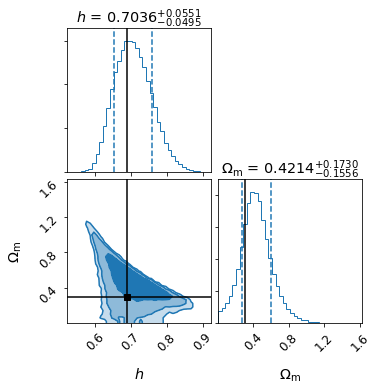

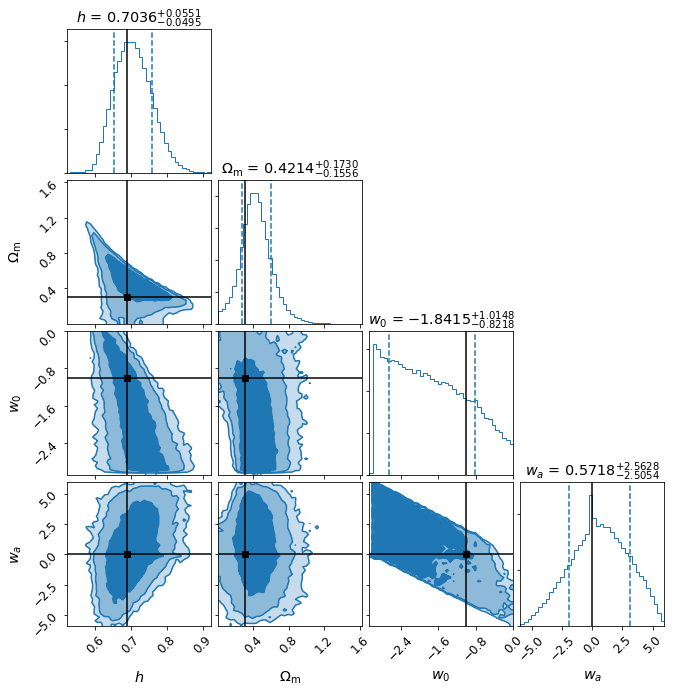

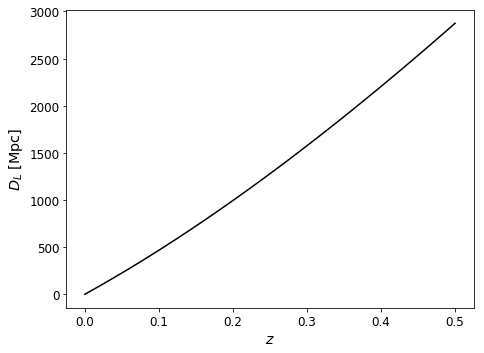

In [117]:
# generate from LCDM infer with w0wa
N = 120
rel_err = 0.13

Truths = [0.69,0.3,-1.0,0.0]
x0 = np.array(Truths)

# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-1.0,wa=0.0)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.0,wa=0.0)
zmax=0.5

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,25)
samples = MCMC_inf4D(DL_res,sigma,False,x0)
post_plot(samples[:,0:2],'GW_10yr_LCDM3.png',Truths,ranges=[(0.52,0.92),(0.0,2.0)])
post_plot(samples[:,0:2],'GW_10yr_LCDM3_zoom.png',Truths,ranges=[(0.52,0.78),(0,1.8)])
post_plot4D(samples,'GW_10yr_LCDM4D.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist_LCDM3.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_LCDM3.png')

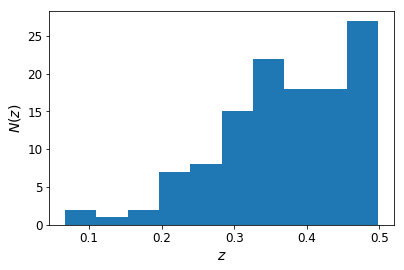

[ 0.69 -1.    0.  ]
124.80405905984935
[ 0.74519982 -2.02842087  4.05684173]
123.94595240458128


/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


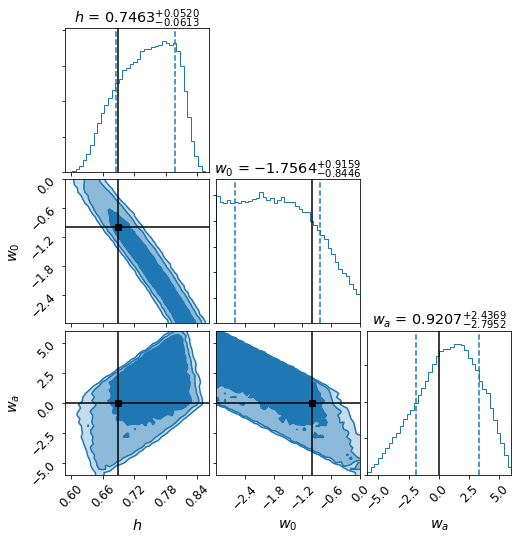

In [125]:
# generate from LCDM infer with w0wa fix Om
N = 120
rel_err = 0.13

Truths = [0.69,-1.0,0.0]
names = [r'$h$',r'$w_0$',r'$w_a$']

x0 = np.array(Truths)

# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-1.0,wa=0.0)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=0.3,w0=-1.0,wa=0.0)
zmax=0.5

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,25)
samples = MCMC_inf4D_fixOm(DL_res,sigma,False,x0)
#post_plot(samples[:,0:2],'GW_10yr_LCDM3_fixOm.png',Truths,names,ranges=[(0.52,0.92),(0.0,2.0)])
#post_plot(samples[:,0:2],'GW_10yr_LCDM3_zoom_fixOm.png',Truths,names,ranges=[(0.52,0.78),(0,1.8)])
post_plot(samples,'GW_10yr_LCDM4D_fixOm.png',Truths,names)
#DL_plot(samples,zmax,w0wa,'GW_10yr_dist_LCDM3.png')
#DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_LCDM3_fixOm.png')

[(0.52, 0.92), (0.0, 2.0)]
[(0.52, 0.78), (0, 1.8)]


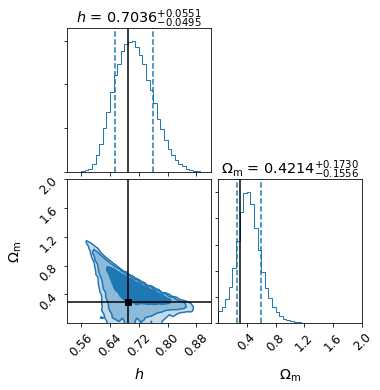

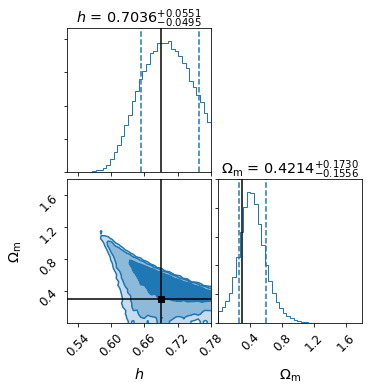

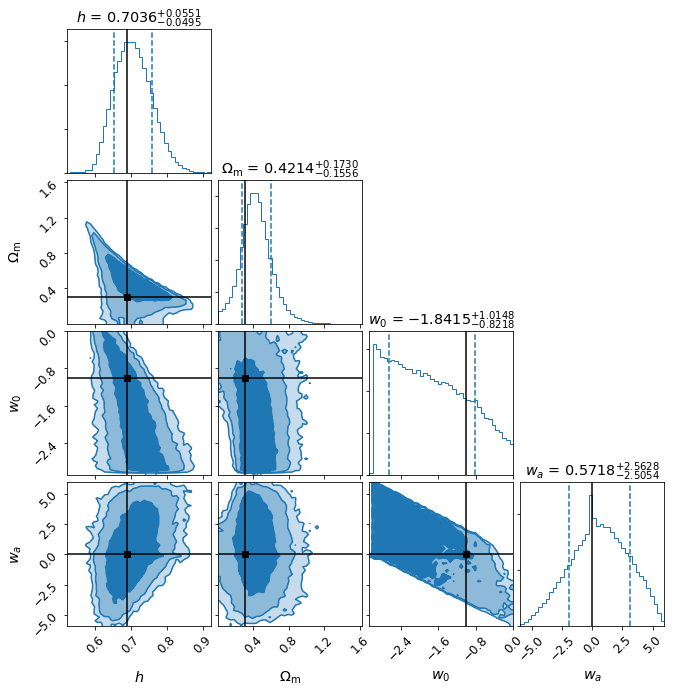

In [122]:
post_plot(samples[:,0:2],'GW_10yr_LCDM3.png',Truths,ranges=[(0.52,0.92),(0.0,2.0)])
post_plot(samples[:,0:2],'GW_10yr_LCDM3_zoom.png',Truths,ranges=[(0.52,0.78),(0,1.8)])
post_plot4D(samples,'GW_10yr_LCDM4D.png',Truths)

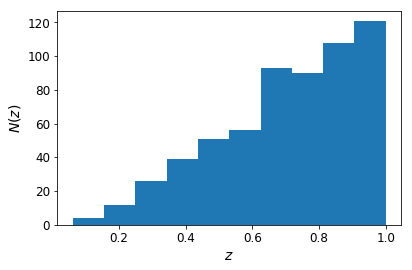

[0.69 0.3 ]
597.6776684815222
[0.70130583 0.24872441]
585.4207052834596


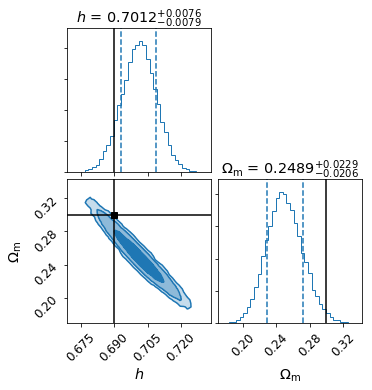

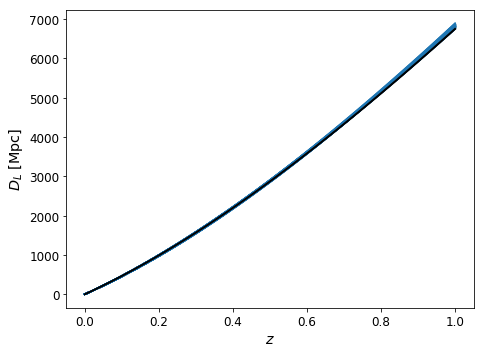

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


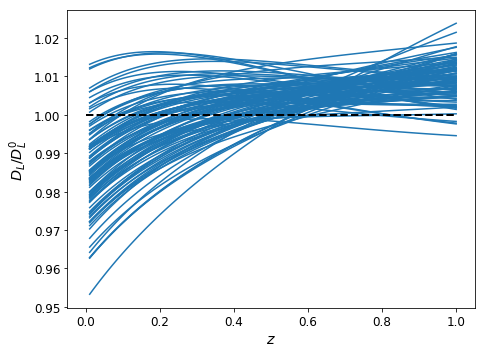

In [63]:
#Far Future Case - w0wa (-0.9,-0.75)
N = 600
rel_err = 0.07
zmax=1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-0.9,wa=-0.75)



z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,48)#47#60#54#6   #48
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_ff_w0wa3.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_ff_dist_w0wa3.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_ff_ratio_w0wa3.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_w0wa.png',[0.689,0.741],[0.7324])

#samples = MCMC_inf1d(DL_res,sigma,0.3153,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_2_w0wa.png',[0.689,0.741],[0.7324])

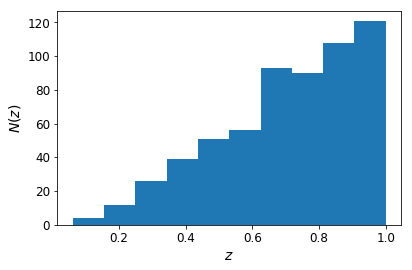

[0.69 0.3 ]
630.7725596507275
[0.68283596 0.28345469]
591.1640211897709


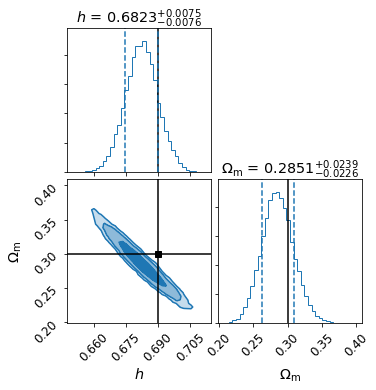

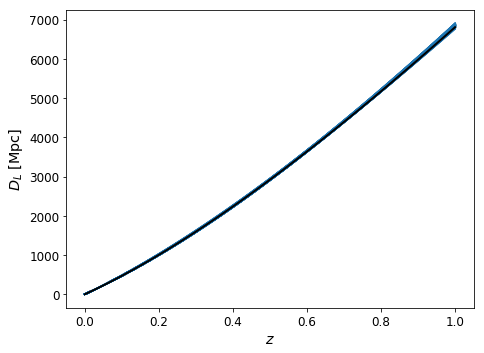

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


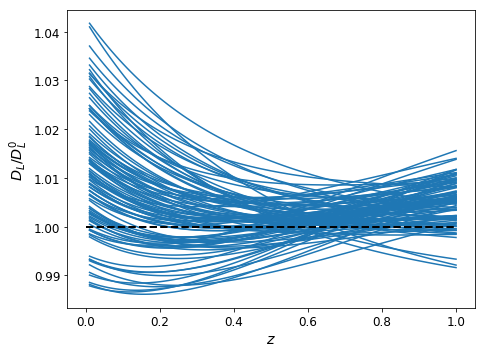

In [65]:
#Far Future Case - w0wa (-1.14,0.35)
N = 600
rel_err = 0.07
zmax=1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.14,wa=0.35)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,54)#54
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_ff_w0wa4.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_ff_dist_w0wa4.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_ff_ratio_w0wa4.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_w0wa.png',[0.689,0.741],[0.7324])

#samples = MCMC_inf1d(DL_res,sigma,0.3153,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_2_w0wa.png',[0.689,0.741],[0.7324])

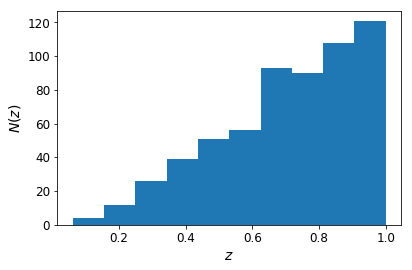

[0.69 0.3 ]
640.2221807340857
[0.68574533 0.27030362]
591.029423200078


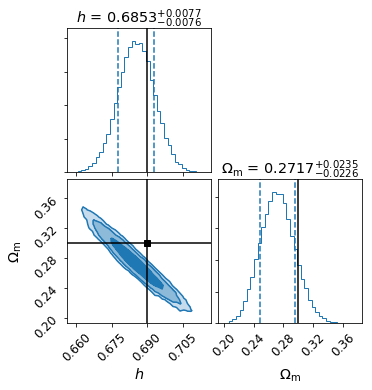

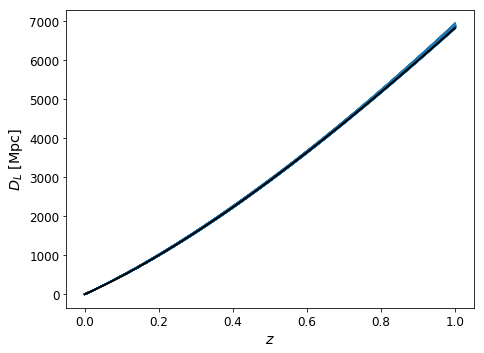

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


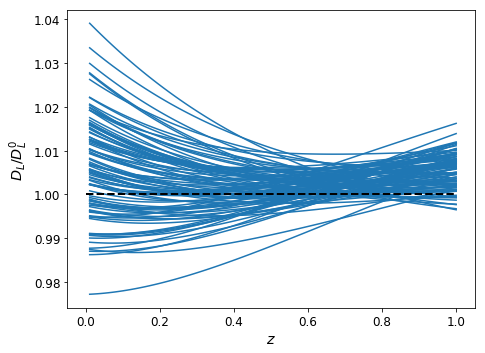

In [71]:
#Far Future Case - w0wa (-1.1,0.0)
N = 600
rel_err = 0.07
zmax=1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.1,wa=0.0)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,54)#54
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_ff_w0wa5.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_ff_dist_w0wa5.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_ff_ratio_w0wa5.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_w0wa.png',[0.689,0.741],[0.7324])

#samples = MCMC_inf1d(DL_res,sigma,0.3153,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_2_w0wa.png',[0.689,0.741],[0.7324])

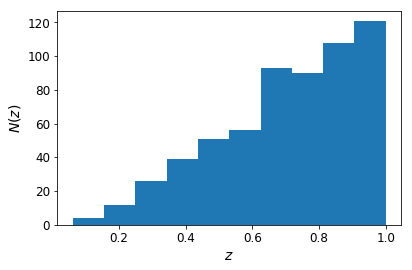

[0.69 0.3 ]
606.3430356912817
[0.6922096  0.29313596]
606.2662261402596


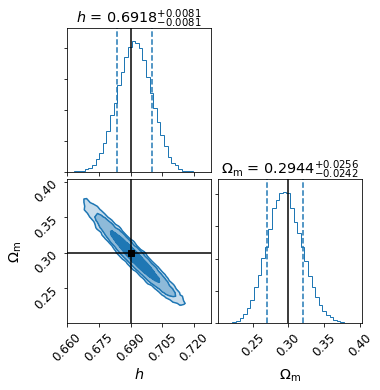

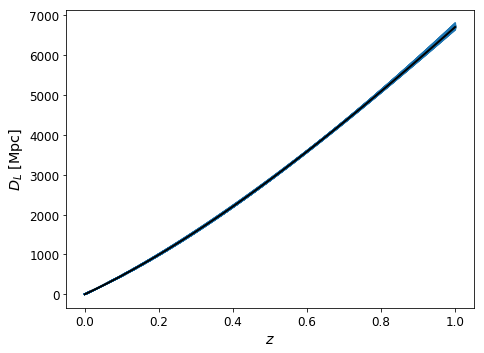

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


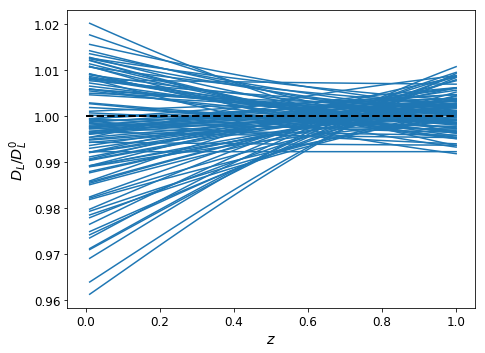

In [61]:
#Far Future Case - LCDM
N = 600
rel_err = 0.07
zmax = 1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)

w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.0,wa=0.0)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,0)
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_ff_lcdm2.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_ff_dist_lcdm2.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_ff_ratio_lcdm2.png')

#samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_lcdm.png',[0.689,0.741],[0.7324])

#samples = MCMC_inf1d(DL_res,sigma,0.3153,np.array([0.7324]))
#post_plot1d(samples,'GW_ff_1D_2_lcdm.png',[0.689,0.741],[0.7324])

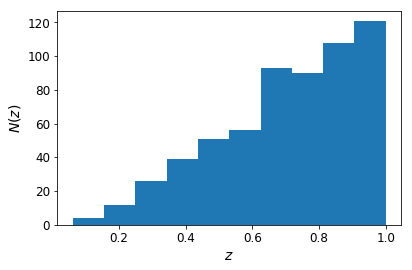

[ 0.69  0.3  -1.    0.  ]
606.3430356912817
[ 0.68112259  0.03703095 -0.64350642  0.48060362]
605.8491734795917


/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:311: RuntimeWarning: invalid value encountered in true_divide


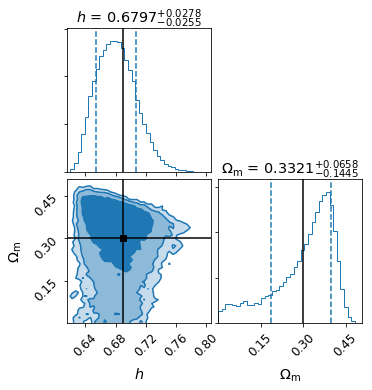

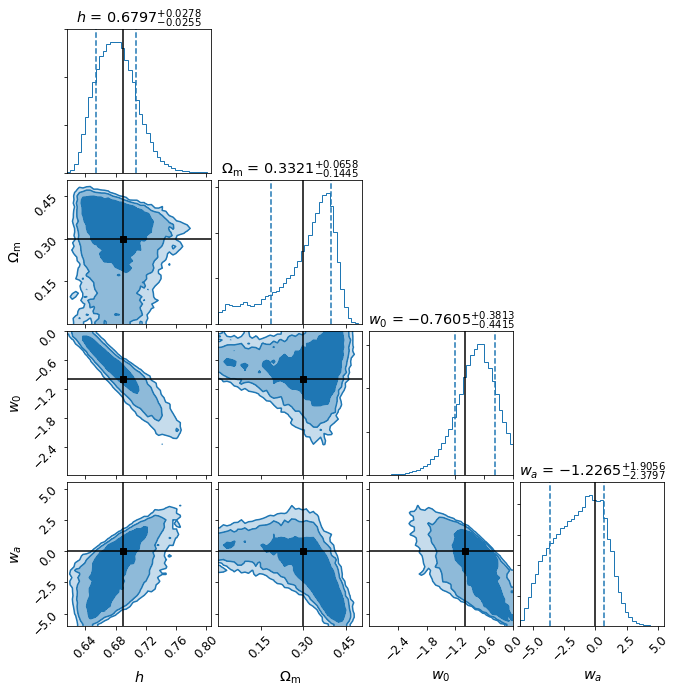

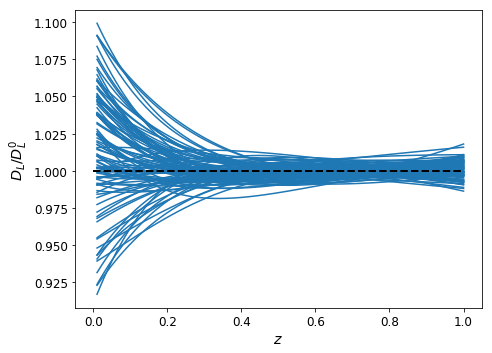

In [113]:
#Far Future Case - LCDM - infer w0wa
N = 600
rel_err = 0.07
zmax = 1.0

Truths = [0.69,0.3,-1.0,0.0]
x0 = np.array(Truths)

w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.0,wa=0.0)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,0)
samples = MCMC_inf4D(DL_res,sigma,False,x0)
post_plot(samples[:,0:2],'GW_ff_lcdm3.png',Truths)
post_plot4D(samples,'GW_ff_lcdm4D.png',Truths)
#DL_plot(samples,zmax,w0wa,'GW_ff_dist_lcdm3.png')
DL_ratio_plot4D(samples,zmax,w0wa,'GW_ff_ratio_lcdm3.png')

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:311: RuntimeWarning: invalid value encountered in true_divide


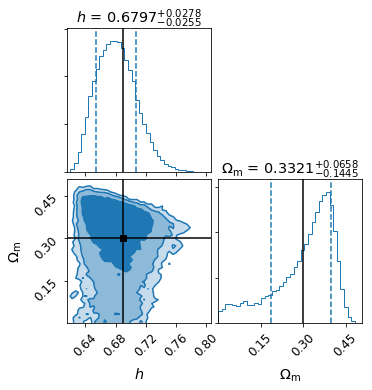

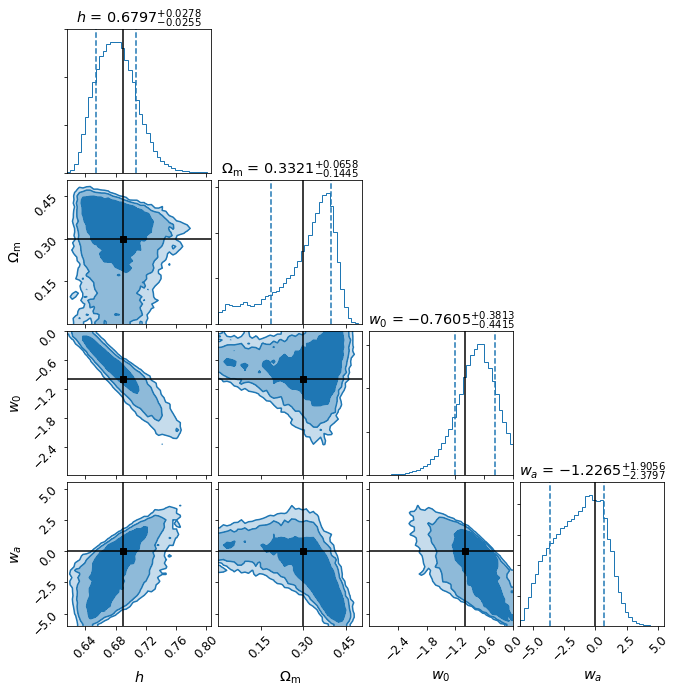

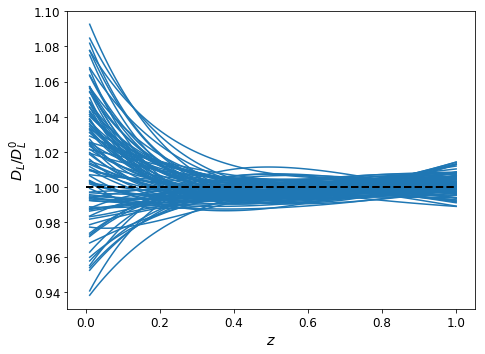

In [114]:
post_plot(samples[:,0:2],'GW_ff_lcdm3.png',Truths)
post_plot4D(samples,'GW_ff_lcdm4D.png',Truths)
#DL_plot(samples,zmax,w0wa,'GW_ff_dist_lcdm3.png')
DL_ratio_plot4D(samples,zmax,w0wa,'GW_ff_ratio_lcdm3.png')

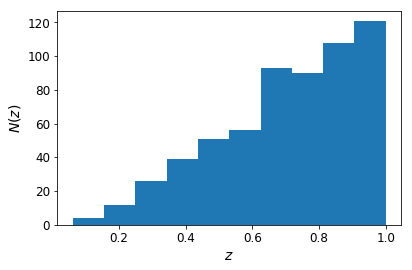

[0.67 0.3 ]
579.1502131390077
[0.66596618 0.31337613]
578.6059792538848


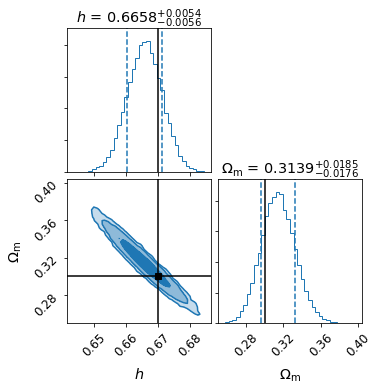

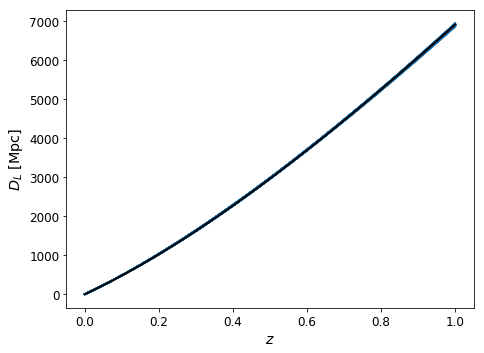

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in true_divide


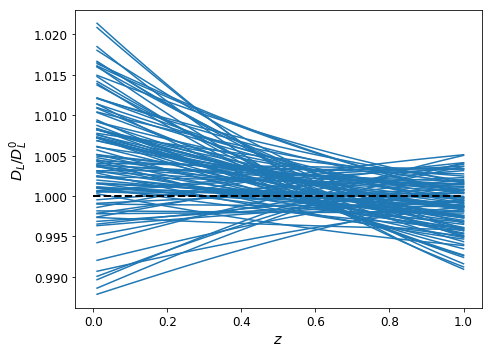

[0.67]
579.1502131390077
[0.67]
579.1502131390077
[0.67]
631.0047679966838
[0.67930356]
584.7233914200962


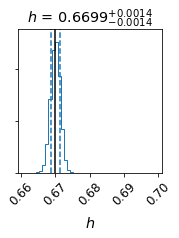

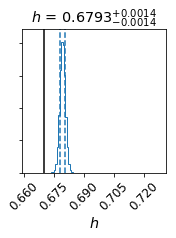

In [23]:
#Far Future Case from Planck LCDM parameters
N = 600
rel_err = 0.07
LCDM = astropy.cosmology.FlatLambdaCDM(H0=67.36,Om0=0.3153)
Truths = [0.6736,0.3153]
x0 = np.array([0.6736,0.3153])
zmax=1.0
z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,LCDM,20)
samples = MCMC_inf(DL_res,sigma,False,x0)
post_plot(samples,'GW_ff_LCDM.png',Truths)
DL_plot(samples,zmax,LCDM,'GW_ff_dist_LCDM.png')
DL_ratio_plot(samples,zmax,LCDM,'GW_ff_ratio_LCDM.png')

samples = MCMC_inf1d(DL_res,sigma,0.3153,np.array([0.6736]))
post_plot1d(samples,'GW_ff_1D_LCDM.png',[0.659,0.701],[0.6736])

samples = MCMC_inf1d(DL_res,sigma,0.2666,np.array([0.6736]))
post_plot1d(samples,'GW_ff_1D2_LCDM.png',[0.659,0.701],[0.6736])

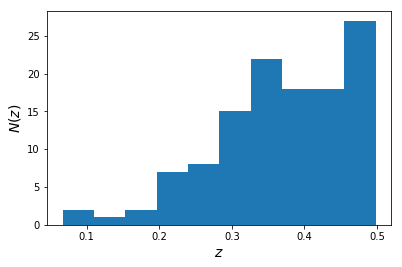

[ 2.  1.  2.  7.  8. 15. 22. 18. 18. 27.] [0.06703704 0.1101552  0.15327336 0.19639152 0.23950969 0.28262785
 0.32574601 0.36886417 0.41198233 0.4551005  0.49821866] <a list of 10 Patch objects>


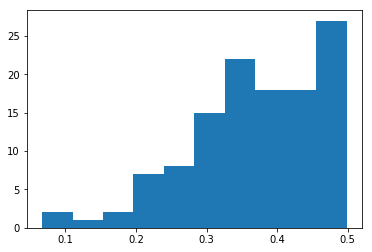

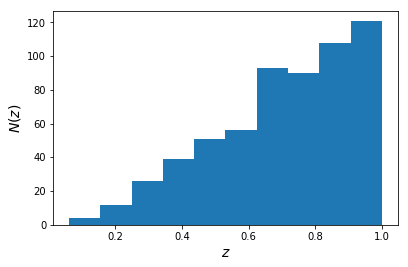

[  4.  12.  26.  39.  51.  56.  93.  90. 108. 121.] [0.06078038 0.15468435 0.24858833 0.34249231 0.43639628 0.53030026
 0.62420424 0.71810821 0.81201219 0.90591617 0.99982015] <a list of 10 Patch objects>


/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


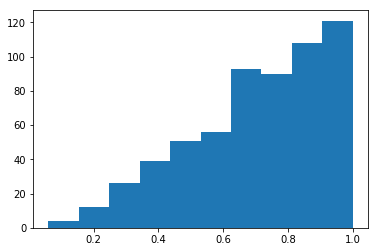

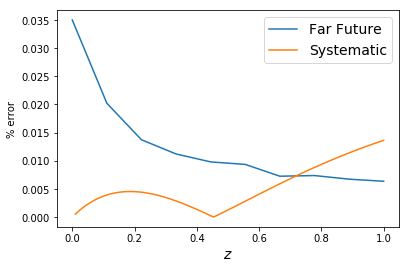

In [4]:
# Do the delta integral / integral and plot it

z = np.linspace(0,1,100)

LCDM = astropy.cosmology.FlatLambdaCDM(H0=73.,Om0=0.25)
w0wa = astropy.cosmology.Flatw0waCDM(H0=73.,Om0=0.25,w0=-0.9,wa=-0.9)
w0wa2 = astropy.cosmology.Flatw0waCDM(H0=73.,Om0=0.25,w0=-0.9,wa=-0.75)

DL_LCDM  =  LCDM.luminosity_distance(z).value
DL_w0wa  =  w0wa.luminosity_distance(z).value
DL_w0wa2  =  w0wa2.luminosity_distance(z).value


z_sample_10yr = z_sampling(120,0.5,42,'GW_z_sample')
Nz_10yr,zpos_10yr,patch_10yr = plt.hist(z_sample_10yr)
print(Nz_10yr,zpos_10yr,patch_10yr)
z_sample_ff = z_sampling(600,1.0,42,'GW_z_sample')
Nz_ff,zpos_ff,patch_ff = plt.hist(z_sample_ff)
print(Nz_ff,zpos_ff,patch_ff)

fig = plt.figure('distances',figsize=(5.5,3.5))
fig.subplots_adjust(left=0.125,bottom=0.13,right=0.99,
                        top=0.99,wspace=0.00,hspace=0.0)
#plt.plot(z,np.sqrt((-1+DL_LCDM/DL_w0wa)**2))
#plt.plot(0.5*(zpos_10yr[:-1]+zpos_10yr[1:]),0.13/np.sqrt(Nz_10yr),label='Near Future')
zplot = 0.5*(zpos_ff[:-1]+zpos_ff[1:])
zplot = zplot - zplot[0]
zplot = zplot*1./zplot[-1]
plt.plot(zplot,0.07/np.sqrt(Nz_ff),label='Far Future')
plt.plot(z,np.sqrt((-1+DL_LCDM/DL_w0wa)**2),label='Systematic')
#plt.plot(z,1-DL_LCDM/DL_w0wa2)
plt.xlabel(r'$z$',fontsize=14)
plt.ylabel('% error')
#plt.ylabel(r'$\Delta$ X / X',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.savefig('Delta_integral.png')
plt.show()

In [ ]:
#Far Future Case - old
N = 600
rel_err = 0.05
w0wa = astropy.cosmology.w0waCDM(H0=73.,Om0=0.25,Ode0=0.75,w0=-0.9,wa=-0.9)
zmax=1.0
z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,20)
samples = MCMC_inf(DL_res,sigma)
post_plot(samples,'GW_ff.png')
DL_plot(samples,zmax,w0wa,'GW_ff_dist2.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_ff_ratio2.png')

samples = MCMC_inf1d(DL_res,sigma,0.25)
post_plot1d(samples,'GW_ff_1D.png',[0.689,0.741])

samples = MCMC_inf1d(DL_res,sigma,0.3)
post_plot1d(samples,'GW_ff_1D_2.png',[0.689,0.741])

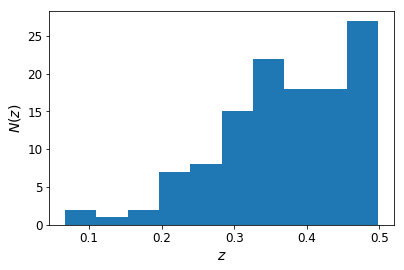

[0.7324 0.2683]
121.62069402179183
[0.71058112 0.28323357]
115.87962284318748


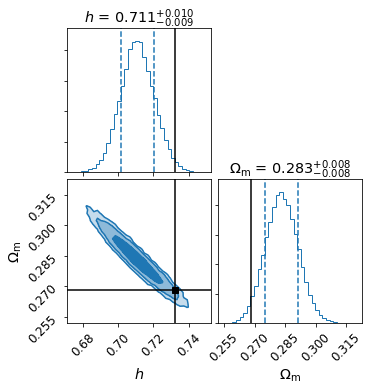

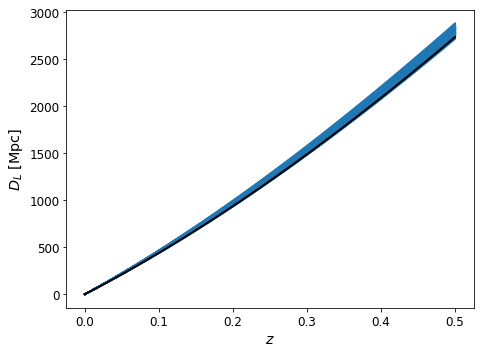

/Users/ryankeeley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in true_divide


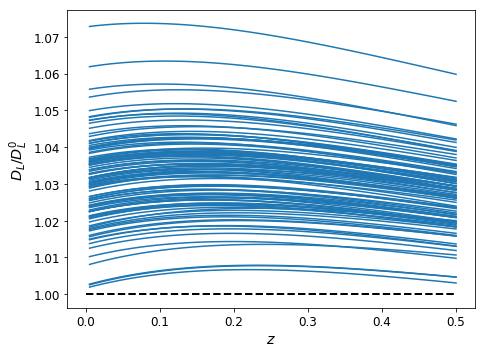

[0.73]
119.76784819941236
[0.71369994]
116.01146192695221
[0.73]
124.56333032516314
[0.70487987]
115.64143352872479


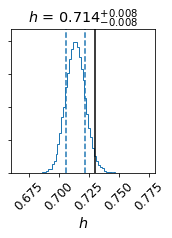

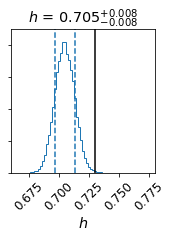

In [20]:
# Realistic Case + CMB
N = 120
rel_err = 0.13
w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2683,Ode0=0.7317,w0=-0.9,wa=-0.75)
zmax=0.5
Truths = [0.7324,0.2683]
x0 = np.array([0.7324,0.2683])

z_sample = z_sampling(N,zmax,42,'GW_z_sample')
DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,19)
samples = MCMC_inf(DL_res,sigma,True,x0)
post_plot(samples,'GW_10yr_CMB.png',Truths)
DL_plot(samples,zmax,w0wa,'GW_10yr_dist_CMB.png')
DL_ratio_plot(samples,zmax,w0wa,'GW_10yr_ratio_CMB.png')

samples = MCMC_inf1d(DL_res,sigma,0.2683)
post_plot1d(samples,'GW_10yr_1D_CMB.png',[0.66,0.78],[0.7324])

samples2 = MCMC_inf1d(DL_res,sigma,0.3153)
post_plot1d(samples2,'GW_10yr_1D_2_CMB.png',[0.66,0.78],[0.7324])


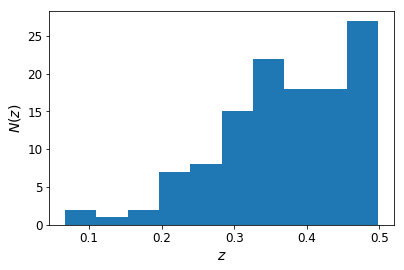

0
8.079063503893721
1
3.7697050712107796
2
0.8866868194580917
3
2.9194539211326003
4
3.4098958691176904
5
0.17014193351425888
6
0.7474459412132717
7
1.9645692485099602
8
0.40850792040561146
9
2.7941966652895758
10
0.10162639946011609
11
0.08325501148155467
12
2.5742968554743584
13
12.275007404075438
14
2.418090006982922
15
1.98910749482215
16
1.4268873093706844
17
2.0516644682121523
18
0.23125076316978266
19
5.695897732904939
20
2.2320384725670976
21
1.9047639981819628
22
1.1144866747933264
23
1.111375764945393
24
0.27329113597866694
25
0.1309423465513646
26
1.1271832550916656
27
1.358904929551528
28
1.4011327008509795
29
0.673546492674916
30
6.570966741730416
31
0.5963025804448421
32
0.016505697427120936
33
1.3737396654288148
34
0.38233906470095746
35
0.08600541404804574
36
3.5497113128748055
37
0.34757169902687224
38
3.953247671815305
39
0.748717819619884
40
0.22352929194164517
41
1.021880049485432
42
4.655698147562035
43
7.186725254508431
44
0.5967890832444027
45
0.37897360209750275

In [15]:
# Realistic Case + CMB
N = 120
rel_err = 0.13
w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-0.9,wa=-0.75)
zmax=0.5
Truths = [0.7324,0.2666]
x0 = np.array([0.7324,0.2666])
#42
z_sample = z_sampling(N,zmax,42,'GW_z_sample')
for i in range(100):
    print(i)
    DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,i)
    samples = dchi2_inf(DL_res,sigma,x0)

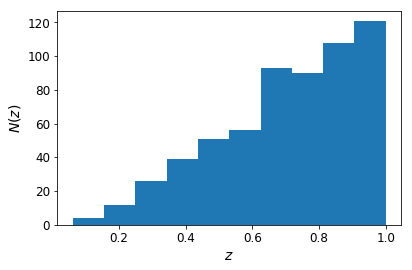

0
[0.74336199 0.23170914]
3.024001850793752
1
[0.7510237  0.20548633]
11.749518978333754
2
[0.75240969 0.20807699]
7.845974711555186
3
[0.74558784 0.22367856]
5.062083495107572
4
[0.7408357  0.24156835]
1.3237702741741941
5
[0.74076749 0.23364974]
4.916015791876021
6
[0.74289065 0.22460391]
8.603337183712938
7
[0.75055839 0.21261554]
6.804454553589721
8
[0.7380487  0.24085402]
4.079769465208301
9
[0.74995864 0.21317528]
7.013512734461983
10
[0.74368535 0.22163199]
9.95021810138826
11
[0.74647766 0.22401578]
4.238957635706015
12
[0.74140236 0.23945971]
1.5525717539426296
13
[0.72214318 0.27121733]
17.593536455622484
14
[0.72865363 0.26551277]
3.906112593457351
15
[0.74314824 0.23483285]
2.119114047971152
16
[0.73549275 0.25496068]
0.47936889958907614
17
[0.75183803 0.21034402]
7.205573462347502
18
[0.73629755 0.25141541]
0.9126546706797853
19
[0.72632829 0.26578932]
9.327120395221414
20
[0.73512156 0.25402225]
0.9512408753857926
21
[0.72852639 0.27072281]
1.4125650864800718
22
[0.739382

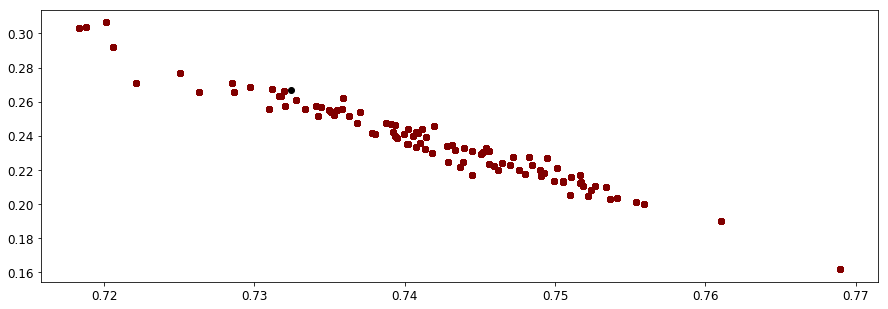

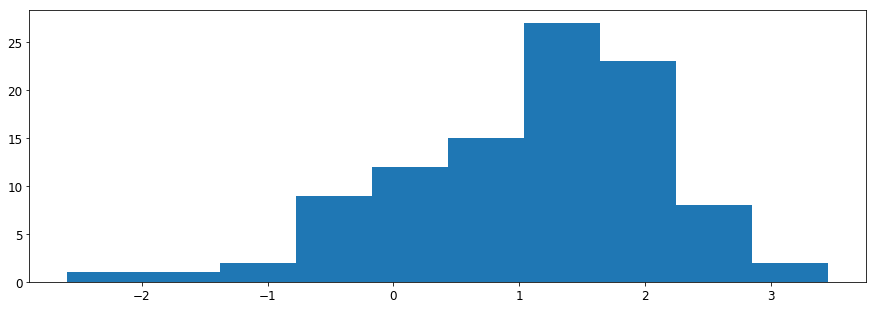

In [36]:
#Far Future Case - w0wa (-0.9,-0.75)
N = 600
rel_err = 0.07
w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-0.9,wa=-0.75)
zmax=1.0
x0 = np.array([0.7324,0.2666])
#42
z_sample = z_sampling(N,zmax,42,'GW_z_sample')
bestfit = np.empty((2,100))
dchi2 = np.empty(100)
for i in range(100):
    print(i)
    DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,i)
    bestfit[:,i],dchi2[i] = dchi2_inf(DL_res,sigma,x0)
    

values = range(100)
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#print scalarMap.get_clim()

for i in range(100):
    #print i
    colorVal = scalarMap.to_rgba(values[i])
    print(colorVal)
    plt.plot(bestfit[0,i],bestfit[1,i],color=colorVal)
    
plt.plot(0.7324,0.2666,'ko')
plt.show()
plt.hist(np.log(dchi2))    
plt.show()

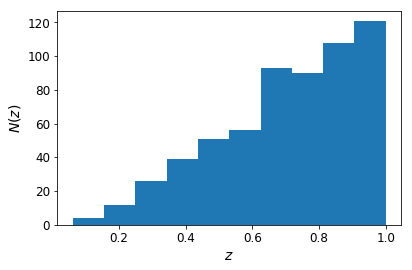

0
[0.69985988 0.26556946]
2.401381841108787
1
[0.70755024 0.2365357 ]
10.540039631351078
2
[0.70855408 0.24012519]
6.817622053191144
3
[0.70204907 0.25681899]
4.22424521570656
4
[0.69760357 0.27559514]
1.0324562852644021
5
[0.69766409 0.26686962]
4.160500883620784
6
[0.6995333 0.2577243]
7.486670932226389
7
[0.70684734 0.24480741]
5.891183693385642
8
[0.69472827 0.27561388]
3.322908704764245
9
[0.70632646 0.24527067]
6.0847632757829615
10
[0.7004397 0.2541227]
8.803555507204237
11
[0.70306327 0.25665349]
3.6111690729018164
12
[0.69783858 0.27428442]
1.1333664495374478
13
[0.67960253 0.3081539 ]
16.52668592514567
14
[0.68571439 0.30218213]
3.387381966516955
15
[0.69961528 0.26899613]
1.6603968466457673
16
[0.69216934 0.29098263]
0.24137999590072923
17
[0.70818407 0.2420349 ]
6.370693053316927
18
[0.6929074  0.28730042]
0.5618475758534487
19
[0.68368306 0.30196344]
8.510940670268042
20
[0.69187435 0.2898206 ]
0.6129371640668069
21
[0.68558268 0.30772084]
1.1711216298592717
22
[0.69612817

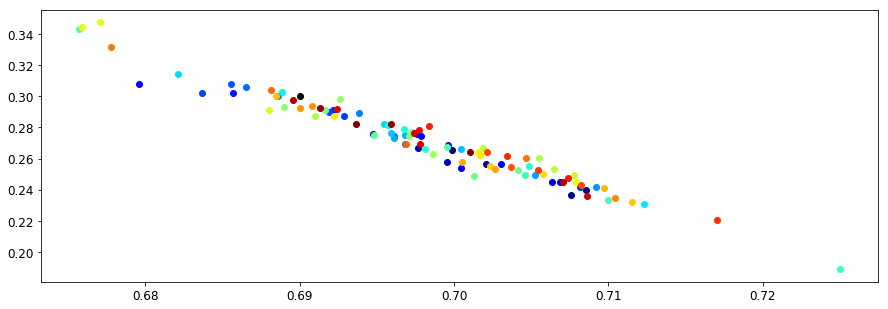

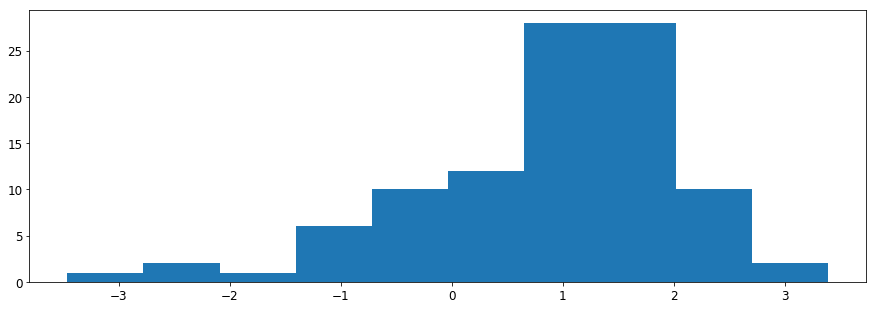

In [62]:
# FF w0wa distribution of realizations
N = 600
rel_err = 0.07
zmax=1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)
# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-1.0,wa=0.0)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-0.9,wa=-0.75)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')

bestfit = np.empty((2,100))
dchi2 = np.empty(100)
for i in range(100):
    print(i)
    DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,i)
    bestfit[:,i],dchi2[i] = dchi2_inf(DL_res,sigma,x0)
    

values = range(100)
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#print scalarMap.get_clim()

for i in range(100):
    #print i
    colorVal = scalarMap.to_rgba(values[i])
    #print(colorVal)
    plt.plot(bestfit[0,i],bestfit[1,i],'o',color=colorVal)
    
plt.plot(0.69,0.3,'ko')
plt.show()
plt.hist(np.log(dchi2))    
plt.show()

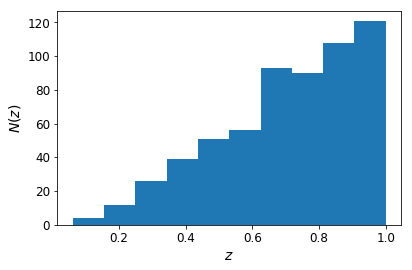

0
[0.68383853 0.28669754]
27.521826109870858
1
[0.69160958 0.25596853]
43.55269611295046
2
[0.69232834 0.26043449]
29.865344571405785
3
[0.68602822 0.27750886]
32.08225726041837
4
[0.68174895 0.2966884 ]
22.05210399643056
5
[0.68188103 0.28746027]
37.47477348827931
6
[0.68357689 0.27842227]
45.61270078546261
7
[0.69074273 0.26503027]
29.64405934012518
8
[0.67876217 0.2972632 ]
37.71278105501949
9
[0.69026181 0.26542567]
31.50788068175268
10
[0.6845743  0.27436743]
48.037646690523275
11
[0.68713563 0.27698721]
27.010812858584472
12
[0.68177008 0.29598711]
23.010798978564026
13
[0.66399911 0.33080836]
76.52427744715567
14
[0.66994127 0.32474218]
42.55889744070112
15
[0.68357286 0.29031773]
22.94034865600395
16
[0.67619467 0.31335039]
24.745649128206082
17
[0.69216439 0.2618316 ]
28.177426507349765
18
[0.67688453 0.30964773]
26.81412370460339
19
[0.66806716 0.32414993]
57.574907049219746
20
[0.67599362 0.31186953]
28.09887328490629
21
[0.66983897 0.33037194]
33.312319941013925
22
[0.68022

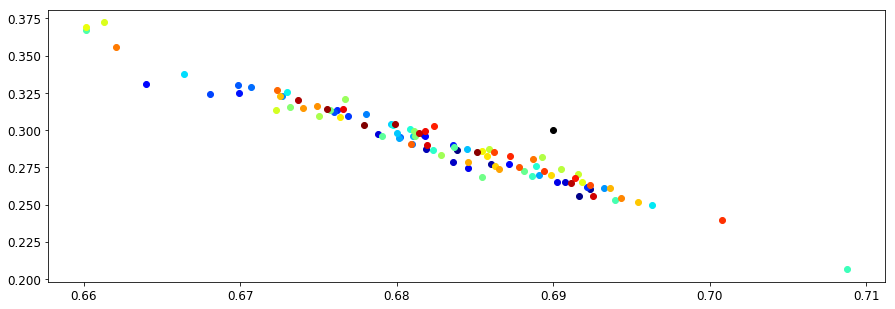

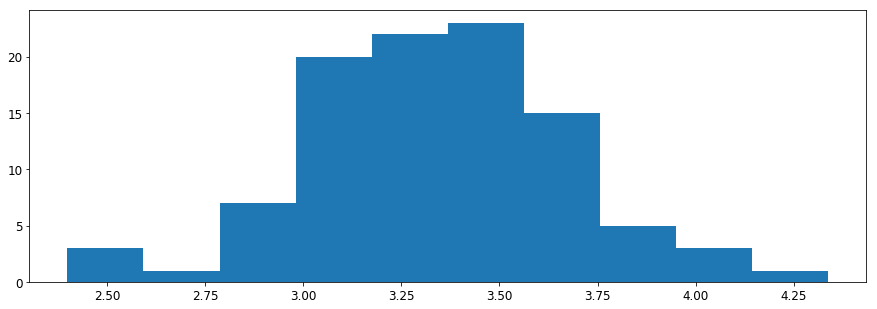

In [64]:
# FF w0wa distribution of realizations w0=-1.14,0.35

N = 600
rel_err = 0.07
zmax=1.0

Truths = [0.69,0.3]
x0 = np.array(Truths)
# \omega_m = 0.143 => \Omega_m = 0.143 as in 1807.06209 table 2 Omh^2 TTTEEE lowE + lensing
#w0wa = astropy.cosmology.w0waCDM(H0=73.24,Om0=0.2666,Ode0=0.7334,w0=-1.0,wa=0.0)
w0wa = astropy.cosmology.Flatw0waCDM(H0=100*Truths[0],Om0=Truths[1],w0=-1.14,wa=0.35)

z_sample = z_sampling(N,zmax,42,'GW_z_sample')

bestfit = np.empty((2,100))
dchi2 = np.empty(100)
for i in range(100):
    print(i)
    DL_res,sigma = DL_sampling(z_sample,rel_err,N,w0wa,i)
    bestfit[:,i],dchi2[i] = dchi2_inf(DL_res,sigma,x0)
    

values = range(100)
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#print scalarMap.get_clim()

for i in range(100):
    #print i
    colorVal = scalarMap.to_rgba(values[i])
    #print(colorVal)
    plt.plot(bestfit[0,i],bestfit[1,i],'o',color=colorVal)
    
plt.plot(0.69,0.3,'ko')
plt.show()
plt.hist(np.log(dchi2))    
plt.show()

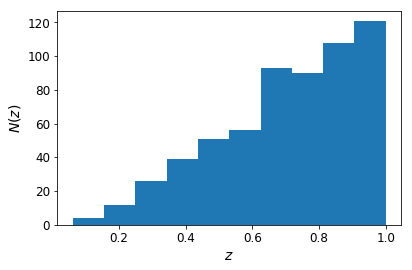

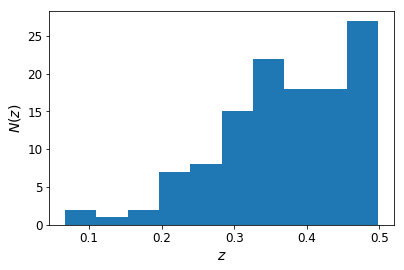

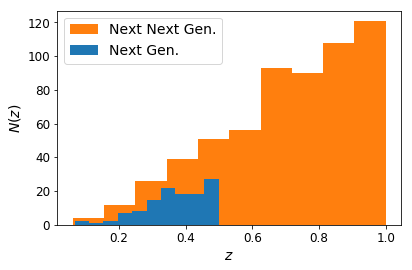

In [134]:
# z distribution overlap plot
z_sample = z_sampling(600,1.0,42,'GW_z_sample')
z_sample2 = z_sampling(120,0.5,42,'GW_z_sample')

fig = plt.figure('redshifts',figsize=(5.5,3.5))
fig.subplots_adjust(left=0.12,bottom=0.14,right=0.99,
                        top=0.99,wspace=0.05,hspace=0.0)
plt.hist(z_sample,color='#ff7f0e',label='Next Next Gen.')
plt.hist(z_sample2,color='#1f77b4',label='Next Gen.')
plt.xlabel(r'$z$',fontsize=14)
plt.ylabel(r'$N(z)$',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.savefig('z_sample_overlap.pdf')
plt.show()
